# Classification of Text Using Multiple Inputs  - Determine Which Passengers Will Survive

In [1]:
# %pip install matplotlib
# %pip install pandas
# %pip install sklearn
# %pip install torch

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

titanic_data = pd.read_csv('../inputs/titanic_train.csv')
titanic_data.head()

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [2]:
# Remove columns that will not help us predict survivability
unwanted_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked']
titanic_data = titanic_data.drop(unwanted_features, axis=1)
# Cleanup
titanic_data = titanic_data.dropna() # Remove rows with missing data
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [3]:
# Convert 'Sex' enums to encoding using fit_transform since there are only 2 possibilities (0 or 1)
le = preprocessing.LabelEncoder()
titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [4]:
# Convert 'Pclass' enum to encoding - using one hot encoding since there are more than 2 possibilities
features = ['Pclass', 'Sex', 'Age', 'Fare']
titanic_features = titanic_data[features]
titanic_features = pd.get_dummies(titanic_features, columns=['Pclass'])
titanic_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [5]:
# Get the target we are trying to predict
titanic_target = titanic_data[['Survived']]
titanic_target.head()

,Survived
0,0
1,1
2,1
3,1
4,0


Epoch 1000 (7%), Loss: 0.711
Epoch 2000 (13%), Loss: 0.681
Epoch 3000 (20%), Loss: 0.658
Epoch 4000 (27%), Loss: 0.640
Epoch 5000 (33%), Loss: 0.622
Epoch 6000 (40%), Loss: 0.603
Epoch 7000 (47%), Loss: 0.584
Epoch 8000 (53%), Loss: 0.568
Epoch 9000 (60%), Loss: 0.554
Epoch 10000 (67%), Loss: 0.541
Epoch 11000 (73%), Loss: 0.531
Epoch 12000 (80%), Loss: 0.521
Epoch 13000 (87%), Loss: 0.512
Epoch 14000 (93%), Loss: 0.504
Epoch 15000 (100%), Loss: 0.496


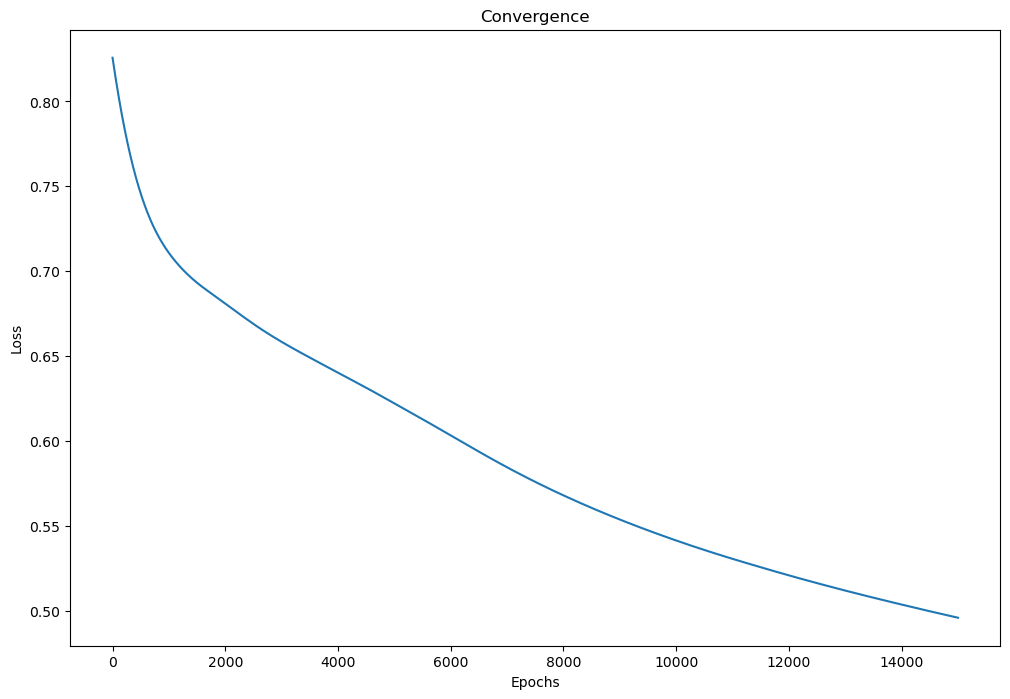

In [6]:
# Split dataset into 80% training data and 20% test data, then convert into tensors
x_train, x_test, y_train, y_test = train_test_split(titanic_features, titanic_target, test_size=0.2, random_state=0)
x_train_tensor = torch.from_numpy(x_train.values).float()
x_test_tensor = torch.from_numpy(x_test.values).float()
y_train_tensor = torch.from_numpy(y_train.values).view(1,-1)[0] # reshape to 1D tensor
y_test_tensor = torch.from_numpy(y_test.values).view(1,-1)[0] # reshape to 1D tensor

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        input_size = 6 # Number of features/columns in our input dataset
        hidden_size = 10
        output_size = 2 # Number of predictions/columns in our output dataset (survived or not)
        # instantiate 3 linear, fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x)) # Activation 0 to 1
        x = torch.sigmoid(self.fc2(x)) # Activation 0 to 1
        x = self.fc3(x) # Linear layer with no activation
        return torch.log_softmax(x, dim=-1) # Classification along with NLL loss log(softmax(x))

model = Net()
criterion = nn.NLLLoss() # Negative log likelihood loss - Useful to train a classification problem with C classes
optimizer = optim.Adam(model.parameters(), lr=0.0001) # First-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments

def train(model, optimizer, criterion, x_train, y_train, num_epochs):
    total_loss = 0
    plot_losses = []
    model.train() # Put the model in "training mode", which turns on dropout and batch normalization
    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        y_predicted = model(x_train)
        loss = criterion(y_predicted, y_train)
        total_loss += loss.item()
        loss.backward() # Determine gradients
        optimizer.step() # Apply gradients
        if epoch % 1000 == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch:.3f}')
        plot_losses.append(total_loss/epoch)
    return plot_losses

plot_losses = train(model, optimizer, criterion, x_train_tensor, y_train_tensor, num_epochs = 15000)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [7]:
def test(model, x, y):
    model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
    with torch.no_grad():
        # make predictions on test set
        y_predicted = model(x)
        # calculate number of correct predictions
        correct = (torch.argmax(y_predicted, dim=1) == y).sum().item()
        # calculate accuracy
        accuracy = 100 * correct / len(y)
    print(f"Test Accuracy: {accuracy:>0.1f}%")

test(model, x_test_tensor, y_test_tensor)

Test Accuracy: 83.2%
